# Aula 4 - ETL - Load

**Objetivos:**

- Aplicar Técnicas de Redução de Dimensão
  - Como constatado no [notebook da aula 2 e 3](./etl_aulas_2_e_3.ipynb), há um desbalanceamento entre as raças dos motoristas - quase 3 vezes mais motoristas brancos. 
  - Aplicar técnicas de undersampling - `easy ensemble`  
  - Analisar novamente utilizando `mutual information` se o atributo mais determinante de ser preso mudou.
- Aplicar Técnicas de Amostragem
    - Aplicar PCA: 
      - Treinar Árvore de Decisão e medir a acurácia 
      - Aplicar o PCA - 
      - Treinar Árvore de Decisão e medir a acurácia 
      - A acurácia mudou?


## Carregando Dataset

In [24]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [25]:
csv_path = "../data/police.csv"
df = pd.read_csv(csv_path)
df.fillna("NA")
df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [26]:
from etl.main import PoliceDatasetEtl


police_dataset_etl = PoliceDatasetEtl(df)
featured_df = police_dataset_etl.clean_transform()

In [27]:
display(featured_df.head())
display(print("Baseline features:"))
display(police_dataset_etl.baseline_features)

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,...,stop_duration,drugs_related_stop,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,is_black_or_hispanic,stop_time_discrete_bins,driver_age_bins,counter
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,155,False,dawn,jovem,1
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,815,False,morning,adulto,1
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,2315,False,night,adulto,1
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,...,16-30 Min,False,5,1,5.0,1715,False,evening,jovem,1
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,1000,False,morning,jovem,1


Baseline features:


None

['is_arrested',
 'driver_race',
 'driver_gender',
 'stop_outcome_level',
 'violation_level',
 'search_conducted',
 'search_type',
 'drugs_related_stop',
 'stop_time_discrete_bins',
 'driver_age_bins']

## Utilizando Mutual Information no Raw Dataset

In [35]:
## Factorization
X = featured_df.copy()
X = X[police_dataset_etl.baseline_features]
X.pop("stop_outcome_level")
y = X.pop("is_arrested")

In [36]:
## Factorization
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

X["stop_time_discrete_bins"], _ = X["stop_time_discrete_bins"].factorize()
X["driver_age_bins"], _ = X["driver_age_bins"].factorize()

discrete_features = X.dtypes == int

In [37]:
## MI Scores
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X,
        y,
        discrete_features=discrete_features,
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show few features with their scores

search_type        0.02585
driver_race        0.00323
driver_age_bins    0.00067
Name: MI Scores, dtype: float64

In [38]:
## Defining Plot Function
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

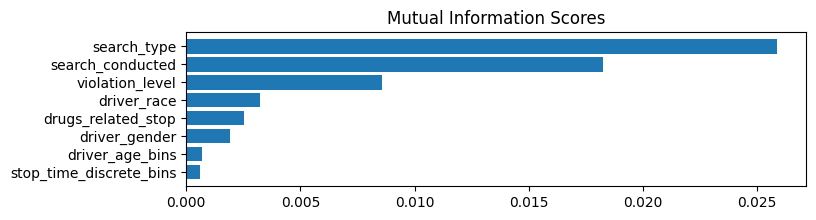

In [39]:
plt.figure(dpi=100, figsize=(8, 2))
plot_mi_scores(mi_scores)

In [51]:
ee_df = featured_df.copy()

white_count = ee_df[ee_df.driver_race == "White"].counter.count()
non_white_count = ee_df[ee_df.driver_race != "White"].counter.count()

display("white drivers:")
display(white_count)

display("non white drivers:")
display(non_white_count)

imbalance = white_count // non_white_count
display("imbalance:")
display(imbalance)

# generate a random sample of white drivers plus the non white drivers
resampled_df_1 = (
    ee_df[ee_df.driver_race == "White"].sample(n=non_white_count, random_state=1).copy()
)

resampled_df_1 = pd.concat(resampled_df_1, ee_df[ee_df.driver_race != "White"].copy())


# Balancing white and non white drivers

'white drivers:'

62158

'non white drivers:'

29583

'imbalance:'

2

TypeError: concat() takes 1 positional argument but 2 were given

## Aplicando Easy Ensemble no Dataset

- Após a aplicação do `easy ensemble`, o atributo mais determinante de ser preso mudou?

## Selecionar Atributos mais Determinantes

## Treinar Uma Árvore de Decisão e Medir a Acurácia

## Aplicar PCA Sobre os Atributos Selecionados Anteriormente

## Treinar Uma Árvore de Decisão Com os K PCAs Mais Relevantes e Medir a Acurácia

- A acurácia melhorou após a aplicação do PCA?